In [1]:
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# Set random seed for reproducibility
torch.manual_seed(12345)
np.random.seed(12345)

In [3]:
dataset = 'detailed'
chosen_feature = ['log_range_value']
test_fold = 1
neurons = 1

In [4]:
# Hinged Square Loss
class SquaredHingeLoss(nn.Module):
    def __init__(self, margin=1):
        super(SquaredHingeLoss, self).__init__()
        self.margin = margin

    def forward(self, predicted, y):
        low, high = y[:, 0:1], y[:, 1:2]
        loss_low = torch.relu(low - predicted + self.margin)
        loss_high = torch.relu(predicted - high + self.margin)
        loss = loss_low + loss_high
        return torch.mean(torch.square(loss))

In [5]:
class SimpleNN(nn.Module):
    def __init__(self, input_size):
        super(SimpleNN, self).__init__()
        self.fc1 = nn.Linear(input_size, neurons)
        self.fc2 = nn.Linear(neurons, 1)
        self.leaky_relu = nn.LeakyReLU(negative_slope=0.01)

    def forward(self, x):
        x = self.leaky_relu(self.fc1(x))
        x = self.fc2(x)
        return x

In [6]:
# Load data
folds_df = pd.read_csv(f'../../training_data/{dataset}/folds.csv')
features_df = pd.read_csv(f'../../training_data/{dataset}/features.csv')[['sequenceID'] + chosen_feature]
target_df = pd.read_csv(f'../../training_data/{dataset}/target.csv')

In [7]:
train_ids = folds_df[folds_df['fold'] != test_fold]['sequenceID']
test_ids = folds_df[folds_df['fold'] == test_fold]['sequenceID']

features_df_train = features_df[features_df['sequenceID'].isin(train_ids)]
features_df_test = features_df[features_df['sequenceID'].isin(test_ids)]
target_df_train = target_df[target_df['sequenceID'].isin(train_ids)]
target_df_test = target_df[target_df['sequenceID'].isin(test_ids)]

X_train = features_df_train[chosen_feature].to_numpy()
y_train = target_df_train.iloc[:, 1:].to_numpy()
X_test = features_df_test[chosen_feature].to_numpy()
y_test = target_df_test.iloc[:, 1:].to_numpy()

X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32)

In [8]:
# Initialize the model, loss function, and optimizer
input_dim = X_train.shape[1]
model = SimpleNN(input_dim)
criterion = SquaredHingeLoss()
optimizer = optim.Adam(model.parameters())

# Training with early stopping
best_train_loss = float('inf')
patience = 5000
patience_counter = 0

for epoch in range(500000):
    model.train()
    optimizer.zero_grad()
    
    # Forward pass
    outputs = model(X_train_tensor)
    loss = criterion(outputs, y_train_tensor)
    
    # Backward pass and optimization
    loss.backward()
    optimizer.step()
    
    # Early stopping check
    train_loss = loss.item()
    if train_loss < best_train_loss:
        best_train_loss = train_loss
        best_model = model.state_dict()  # Save the best model state
        patience_counter = 0
    else:
        patience_counter += 1
    
    if patience_counter >= patience:
        break

# Load the best model
model.load_state_dict(best_model)

# Predict on the test set
model.eval()
y_pred = model(X_test_tensor).detach().numpy().ravel()

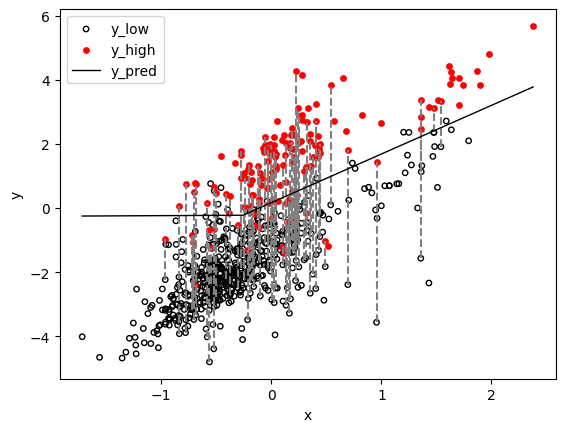

In [9]:
# Sample data
x = X_test_tensor.numpy()
y_low = y_test_tensor.numpy()[:,0]
y_high = y_test_tensor.numpy()[:,1]

# Create a figure and axis
fig, ax = plt.subplots()

# Scatter plot for x vs y_low and x vs y_high
ax.scatter(x, y_low, color='blue', edgecolor='black', marker='o', label='y_low', facecolors='none', s=15)
ax.scatter(x, y_high, color='red', marker='o', label='y_high', s=15)

# Draw vertical lines from y_low to y_high
for xi, yi_low, yi_high in zip(x, y_low, y_high):
    ax.plot([xi, xi], [yi_low, yi_high], color='gray', linestyle='--')

# Draw piecewise line for x vs y_pred
x_model = np.linspace(x.min(), x.max(), 1000).reshape(-1,1)
y_model = model(torch.tensor(x_model, dtype=torch.float32)).detach().numpy().ravel()
ax.plot(x_model, y_model, color='black', label='y_pred', linestyle='-', linewidth=1)

# Add labels and legend
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.legend()

# Show the plot
plt.show()